# Evaluate other models from tabsyn repo

* tabddpm
* stasy
* codi
* great

Evaluate models trained in RunMany notebook

In [10]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def get_features(df):
    agg_dict = {
        'LABEL': ('LABEL', 'max'),
        'cnt': ('LABEL', 'count'),
        'min_ts': ('TIMESTAMP', 'min'),
        'max_ts': ('TIMESTAMP', 'max')
    }
    agg_dict.update({f'mean_{c}': (c, 'mean')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    agg_dict.update({f'max_{c}': (c, 'max')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    df_agg = df.groupby('USERID').agg(**agg_dict).reset_index()
    df_agg['dur'] = df_agg['max_ts'] - df_agg['min_ts']
    del df_agg['max_ts'], df_agg['min_ts']
    return df_agg

In [11]:
def eval_model(df_train, df_test, mode):
    X_train = df_train.copy()
    y_train = X_train.pop('LABEL')
    X_test = df_test.copy()
    y_test = X_test.pop('LABEL')
    xgb = XGBClassifier(n_estimators=30, max_depth=5, learning_rate=.1, objective='binary:logistic', verbosity=1)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    metrics = {'mode': mode,
               'cnt_rows_train': y_train.shape[0],
               'cnt_ones_train': (y_train == 1).sum(),
               'F1_train': f1_score(y_train, y_pred_train),
               'F1_test': f1_score(y_test, y_pred_test)}
    return metrics

## TabDDPM

In [1]:
import pandas as pd
df_syn = pd.read_csv('synthetic/act-mooc/sampled.csv')
df_syn.shape

(271341, 8)

In [2]:
df_train = pd.read_csv('act-mooc-train.csv.gz')
df_test = pd.read_csv('act-mooc-test.csv.gz')

In [3]:
df_syn['LABEL'].value_counts()

LABEL
0    137048
1    134293
Name: count, dtype: int64

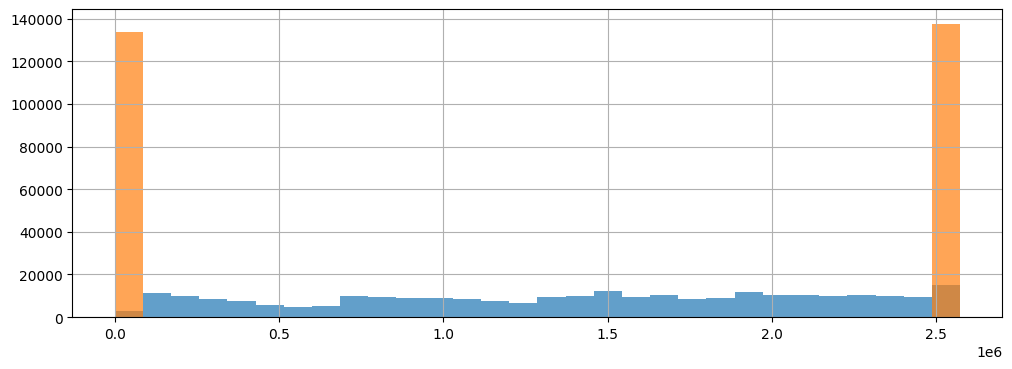

In [4]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].hist(alpha=.7, bins=30)
legend = ['real', 'syn']

In [5]:
df_syn.head()

,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,4709,38,0.0,-0.319991,98.796790,151.415180,-0.067309,1
1,3400,38,0.0,25.293571,-0.435701,-0.394237,-0.067309,1
2,3059,18,2572086.0,25.293571,-0.435701,151.415180,183.970920,1
3,3627,67,2572086.0,-0.319991,-0.435701,151.415180,183.970920,1
4,1325,9,0.0,25.293571,98.796790,151.415180,-0.067309,1


In [6]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn[col].value_counts().rename('Syn'),
], axis=1)

,Real,Syn
LABEL,,
0,268474,137048
1,2867,134293


In [7]:
for col in ['USERID', 'TARGETID']:
    print(f'{col}: real - {df_train[col].nunique()}, {df_syn[col].nunique()}')

USERID: real - 4932, 4932
TARGETID: real - 97, 97


In [10]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_syn_feat = get_features(df_syn)
df_train_feat.shape, df_test_feat.shape, df_syn_feat.shape

((4932, 12), (2115, 12), (4932, 12))

In [11]:
df_syn_feat = df_syn_feat.astype(df_train_feat.dtypes)

In [12]:
df_eval = pd.DataFrame([
    eval_model(df_syn_feat, df_test_feat, 'TSTR'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR,4932,4928,0.999594,0.723597
1,TRTR,4932,2867,0.866609,0.827356


## GReaT

In [1]:
import pandas as pd
df_syn = pd.read_csv('synthetic/act-mooc/great.csv')
df_syn.shape

(244206, 8)

In [2]:
df_train = pd.read_csv('act-mooc-train.csv.gz')
df_test = pd.read_csv('act-mooc-test.csv.gz')

In [3]:
df_syn['LABEL'].value_counts()

LABEL
0.0    241627
1.0      2579
Name: count, dtype: int64

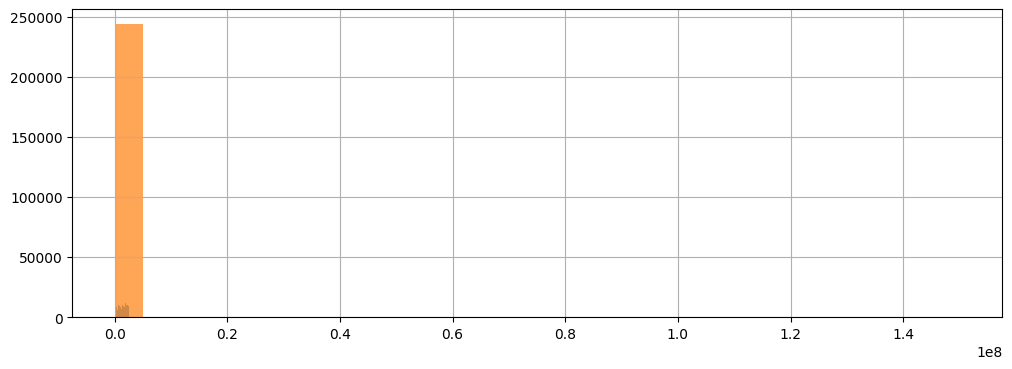

In [4]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].hist(alpha=.7, bins=30)
legend = ['real', 'syn']

In [5]:
df_syn.head()

,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,1654.0,79.0,2017481.0,-0.319991,-0.435701,0.106784,-0.067309,0.0
1,6354.0,14.0,1750410.0,2.376173,-0.435701,-0.394237,-0.067309,0.0
2,1001.0,26.0,715251.0,-0.319991,-0.435701,0.106784,-0.067309,0.0
3,702.0,39.0,2257908.0,-0.319991,-0.435701,0.106784,-0.067309,0.0
4,1751.0,6.0,717092.0,-0.319991,-0.435701,0.106784,-0.067309,0.0


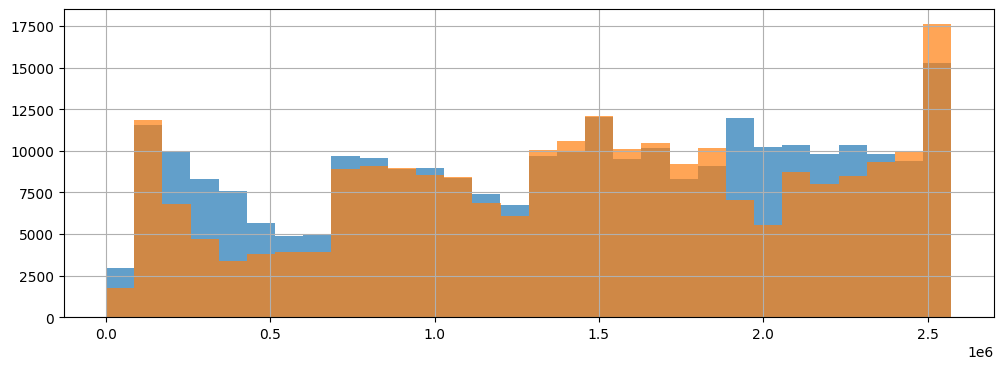

In [6]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].clip(upper=df_train['TIMESTAMP'].max()).hist(alpha=.7, bins=30)
legend = ['real', 'syn']

In [7]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn[col].value_counts().rename('Syn'),
], axis=1)

,Real,Syn
LABEL,,
0,268474,241627
1,2867,2579


In [8]:
for col in ['USERID', 'TARGETID']:
    print(f'{col}: real - {df_train[col].nunique()}, {df_syn[col].nunique()}')

USERID: real - 4932, 4587
TARGETID: real - 97, 97


In [12]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_syn_feat = get_features(df_syn)
df_train_feat.shape, df_test_feat.shape, df_syn_feat.shape

((4932, 12), (2115, 12), (4587, 12))

In [13]:
df_syn_feat = df_syn_feat.astype(df_train_feat.dtypes)

In [14]:
df_eval = pd.DataFrame([
    eval_model(df_syn_feat, df_test_feat, 'TSTR'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR,4587,1501,0.517709,0.289107
1,TRTR,4932,2867,0.866609,0.827356
